# Import necessary library

In [1]:

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import random
from pprint import pprint

# Load and Prepare Data


In [24]:
dataset = pd.read_csv("Iris.csv")
dataset.drop('Id', axis=1, inplace=True)
dataset.columns=['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm',
       'label']

In [26]:
dataset.columns

Index(['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm',
       'label'],
      dtype='object')

In [27]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
SepalLengthCm    150 non-null float64
SepalWidthCm     150 non-null float64
PetalLengthCm    150 non-null float64
PetalWidthCm     150 non-null float64
label            150 non-null object
dtypes: float64(4), object(1)
memory usage: 5.9+ KB


# Observe the dataset for preporcessing

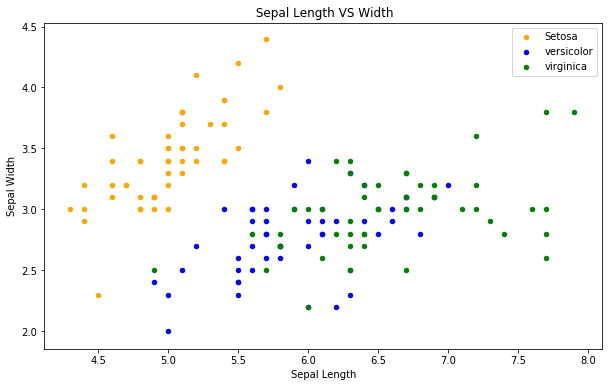

In [29]:
fig = dataset[dataset.label == 'Iris-setosa'].plot(kind='scatter', x='SepalLengthCm', y='SepalWidthCm',
                                                     color='orange', label='Setosa')
dataset[dataset.label=='Iris-versicolor'].plot(kind='scatter',x='SepalLengthCm',y='SepalWidthCm',color='blue', 
                                           label='versicolor',ax=fig)
dataset[dataset.label=='Iris-virginica'].plot(kind='scatter',x='SepalLengthCm',y='SepalWidthCm',color='green', 
                                          label='virginica', ax=fig)
fig.set_xlabel("Sepal Length")
fig.set_ylabel("Sepal Width")
fig.set_title(" Sepal Length VS Width")
fig=plt.gcf()
fig.set_size_inches(10,6)
plt.show()

# Split the dataset

In [30]:
def train_test_split(df, test_size):
    
    if isinstance(test_size, float):
        test_size = round(test_size * len(df))

    indices = df.index.tolist()
    test_indices = random.sample(population=indices, k=test_size)

    test_df = df.loc[test_indices]
    train_df = df.drop(test_indices)
    
    return train_df, test_df

In [31]:

random.seed(0)
train_df, test_df = train_test_split(dataset, test_size=20)

# Helper Functions

In [32]:
data = train_df.values
data[:5]

array([[5.1, 3.5, 1.4, 0.2, 'Iris-setosa'],
       [4.9, 3.0, 1.4, 0.2, 'Iris-setosa'],
       [4.7, 3.2, 1.3, 0.2, 'Iris-setosa'],
       [4.6, 3.1, 1.5, 0.2, 'Iris-setosa'],
       [5.0, 3.6, 1.4, 0.2, 'Iris-setosa']], dtype=object)

# Data purity check

In [33]:

def check_purity(data):
    
    label_column = data[:, -1]
    unique_classes = np.unique(label_column)

    if len(unique_classes) == 1:
        return True
    else:
        return False

# Classify

In [34]:

def classify_data(data):
    
    label_column = data[:, -1]
    unique_classes, counts_unique_classes = np.unique(label_column, return_counts=True)

    index = counts_unique_classes.argmax()
    classification = unique_classes[index]
    
    return classification

# Potential splits?

In [35]:
def get_potential_splits(data):
    
    potential_splits = {}
    _, n_columns = data.shape
    for column_index in range(n_columns - 1):          # excluding the last column which is the label
        values = data[:, column_index]
        unique_values = np.unique(values)
        
        potential_splits[column_index] = unique_values
    
    return potential_splits

# Split Data for Classification

In [36]:
def split_data(data, split_column, split_value):
    
    split_column_values = data[:, split_column]

    type_of_feature = FEATURE_TYPES[split_column]
    if type_of_feature == "continuous":
        data_below = data[split_column_values <= split_value]
        data_above = data[split_column_values >  split_value]
    
    # feature is categorical   
    else:
        data_below = data[split_column_values == split_value]
        data_above = data[split_column_values != split_value]
    
    return data_below, data_above

# Lowest Overall Entropy?

In [37]:
def calculate_entropy(data):
    
    label_column = data[:, -1]
    _, counts = np.unique(label_column, return_counts=True)

    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))
     
    return entropy

In [38]:
def calculate_overall_entropy(data_below, data_above):
    
    n = len(data_below) + len(data_above)
    p_data_below = len(data_below) / n
    p_data_above = len(data_above) / n

    overall_entropy =  (p_data_below * calculate_entropy(data_below) 
                      + p_data_above * calculate_entropy(data_above))
    
    return overall_entropy

In [39]:

def determine_best_split(data, potential_splits):
    
    overall_entropy = 9999
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(data, split_column=column_index, split_value=value)
            current_overall_entropy = calculate_overall_entropy(data_below, data_above)

            if current_overall_entropy <= overall_entropy:
                overall_entropy = current_overall_entropy
                best_split_column = column_index
                best_split_value = value
    
    return best_split_column, best_split_value

# Decision Tree Algorithm

<h3> Representation of the Decision Tree </h3>

In [40]:
#sub_tree = {question: [yes_answer, no_answer]}
example_tree = {"petal_width <= 0.8": ["Iris-setosa", 
                                       {"petal_width <= 1.65": [{"petal_length <= 4.9": ["Iris-versicolor", 
                                                                                         "Iris-virginica"]}, 
                                                                "Iris-virginica"]}]}

# Determine Type of Feature

In [41]:
def determine_type_of_feature(df):
    
    feature_types = []
    n_unique_values_treshold = 15
    for feature in df.columns:
        if feature != "label":
            unique_values = df[feature].unique()
            example_value = unique_values[0]

            if (isinstance(example_value, str)) or (len(unique_values) <= n_unique_values_treshold):
                feature_types.append("categorical")
            else:
                feature_types.append("continuous")
    
    return feature_types

# Algorithm

In [42]:
def decision_tree_algorithm(df, counter=0, min_samples=2, max_depth=5):
    
    # data preparations
    if counter == 0:
        global COLUMN_HEADERS, FEATURE_TYPES
        COLUMN_HEADERS = df.columns
        FEATURE_TYPES = determine_type_of_feature(df)
        data = df.values
    else:
        data = df           
    
    
    # base cases
    if (check_purity(data)) or (len(data) < min_samples) or (counter == max_depth):
        classification = classify_data(data)
        
        return classification

    
    # recursive part
    else:    
        counter += 1

        # helper functions 
        potential_splits = get_potential_splits(data)
        split_column, split_value = determine_best_split(data, potential_splits)
        data_below, data_above = split_data(data, split_column, split_value)
        
        # check for empty data
        if len(data_below) == 0 or len(data_above) == 0:
            classification = classify_data(data)
            return classification
        
        # determine question
        feature_name = COLUMN_HEADERS[split_column]
        type_of_feature = FEATURE_TYPES[split_column]
        if type_of_feature == "continuous":
            question = "{} <= {}".format(feature_name, split_value)
            
        # feature is categorical
        else:
            question = "{} = {}".format(feature_name, split_value)
        
        # instantiate sub-tree
        sub_tree = {question: []}
        
        # find answers (recursion)
        yes_answer = decision_tree_algorithm(data_below, counter, min_samples, max_depth)
        no_answer = decision_tree_algorithm(data_above, counter, min_samples, max_depth)
        
        # If the answers are the same, then there is no point in asking the qestion.
        # This could happen when the data is classified even though it is not pure
        # yet (min_samples or max_depth base case).
        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)
        
        return sub_tree

In [43]:

tree = decision_tree_algorithm(train_df, max_depth=3)
pprint(tree)

{'PetalWidthCm <= 0.6': ['Iris-setosa',
                         {'PetalWidthCm <= 1.6': [{'PetalLengthCm <= 4.9': ['Iris-versicolor',
                                                                            'Iris-virginica']},
                                                  'Iris-virginica']}]}


# Classification

In [44]:
example = test_df.iloc[0]
example

SepalLengthCm                5.1
SepalWidthCm                 2.5
PetalLengthCm                  3
PetalWidthCm                 1.1
label            Iris-versicolor
Name: 98, dtype: object

In [45]:
test_df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,label
98,5.1,2.5,3.0,1.1,Iris-versicolor
107,7.3,2.9,6.3,1.8,Iris-virginica
10,5.4,3.7,1.5,0.2,Iris-setosa
66,5.6,3.0,4.5,1.5,Iris-versicolor
130,7.4,2.8,6.1,1.9,Iris-virginica


In [51]:
def classify_example(example, tree):
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.split(" ")
    # ask question
    if comparison_operator == "<=":
        if example[feature_name] <= float(value):
            answer = tree[question][0]
        else:
            answer = tree[question][1]
    
    # feature is categorical
    else:
        if str(example[feature_name]) == value:
            answer = tree[question][0]
        else:
            answer = tree[question][1]

    # base case
    if not isinstance(answer, dict):
        return answer
    
    # recursive part
    else:
        residual_tree = answer
        return classify_example(example,residual_tree)

In [52]:
def Predict(datas, tree):
    len = test_df.shape[0]
    result = []
    for i in range(len):
        result.append(classify_example(test_df.iloc[i],tree))

    return np.array(result)

# Calculate Accuracy

In [48]:
def calculate_accuracy(df, tree):

    df["classification"] = df.apply(classify_example, args=(tree,), axis=1)
    df["classification_correct"] = df["classification"] == df["label"]
    
    accuracy = df["classification_correct"].mean()
    
    return accuracy

In [55]:
accuracy = calculate_accuracy(test_df, tree)
print('The accuracy of the Decision Tree is',accuracy)

The accuracy of the Decision Tree is 0.95
